In [347]:
import pandas as pd
import sqlite3

In [348]:
connect_db = sqlite3.connect('../data/checking-logs.sqlite.sqlite')
query = 'PRAGMA table_info(checker);'
pd.io.sql.read_sql(query, connect_db)

,cid,name,type,notnull,dflt_value,pk
0,0,index,INTEGER,0,None,0
1,1,status,TEXT,0,None,0
2,2,success,INTEGER,0,None,0
3,3,timestamp,TIMESTAMP,0,None,0
4,4,numTrials,INTEGER,0,None,0
5,5,labname,TEXT,0,None,0
6,6,uid,TEXT,0,None,0


In [349]:
query = '''
        select uid, timestamp from checker where uid like 'user_%'
        '''
df = pd.io.sql.read_sql(query, connect_db, parse_dates=['timestamp'])
df.head()

,uid,timestamp
0,user_4,2020-04-17 05:19:02.744528
1,user_4,2020-04-17 05:22:35.249331
2,user_4,2020-04-17 05:22:45.549397
3,user_4,2020-04-17 05:34:14.691200
4,user_4,2020-04-17 05:34:24.422370


In [350]:
df['date'] = df.timestamp.dt.date
df['hour'] = df.timestamp.dt.hour
interval = ['nigth', 'morning', 'afternoon', 'evening']
df['daytime'] = pd.cut(df['hour'], [0, 4, 10, 17, 24], labels=interval, include_lowest=True, right=False)


In [351]:
for_plot = df.groupby(by=['date', 'daytime']).count()['hour'].reset_index()
for_plot.hour.fillna(0, inplace=True)
for_plot

,date,daytime,hour
0,2020-04-17,nigth,0.0
1,2020-04-17,morning,13.0
2,2020-04-17,afternoon,10.0
3,2020-04-17,evening,0.0
4,2020-04-18,nigth,0.0
...,...,...,...
135,2020-05-20,evening,10.0
136,2020-05-21,nigth,0.0
137,2020-05-21,morning,1.0
138,2020-05-21,afternoon,27.0


In [352]:
for_plot_pivot = pd.pivot(for_plot, values='hour', index='date', columns='daytime')
for_plot_pivot.head()

daytime,nigth,morning,afternoon,evening
date,,,,
2020-04-17,0.0,13.0,10.0,0.0
2020-04-18,0.0,1.0,33.0,35.0
2020-04-19,2.0,4.0,16.0,11.0
2020-04-20,0.0,0.0,12.0,13.0
2020-04-21,0.0,0.0,0.0,25.0


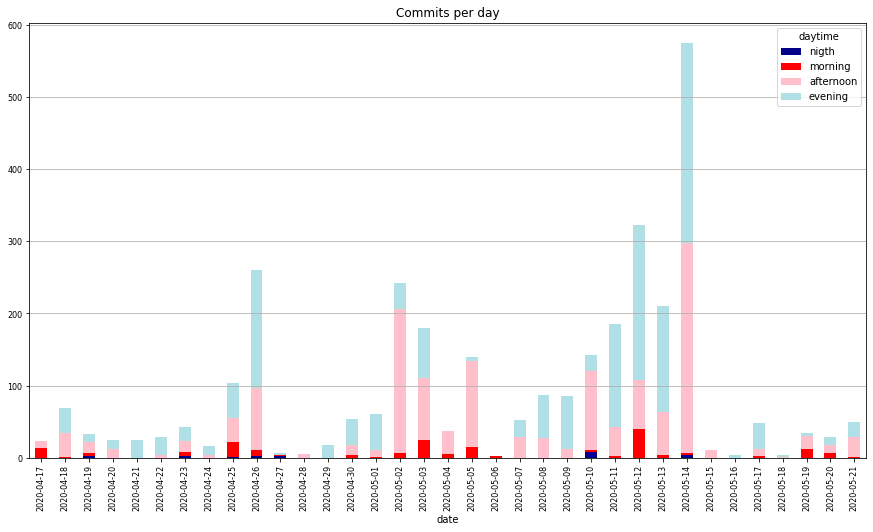

In [353]:
plot = for_plot_pivot.plot(kind='bar', figsize= (15,8), title = 'Commits per day', fontsize=8, xlabel = 'date', rot = 90, color = ['#00008B', 'red', '#FFC0CB', '#B0E0E6'], stacked=True)
plot.grid('on', which='major', axis='y')

When do our users usually commit the labs: in the night, morning, afternoon, or evening?

In [354]:
s = {'evening':for_plot_pivot.evening.sum(), 'morning':for_plot_pivot.morning.sum(), 'afternoon':for_plot_pivot.afternoon.sum(), 'nigth':for_plot_pivot.nigth.sum()}
dict(sorted(s.items(), key=lambda item: item[1]))

{'afternoon': 1391.0, 'evening': 1611.0, 'morning': 184.0, 'nigth': 21.0}


evening and afternoon


Which day has the most number of commits and at the same time the number of commits in the evening is higher than in the afternoon?

In [355]:
for_plot_pivot[for_plot_pivot.evening > for_plot_pivot.afternoon].sum(axis=1).sort_values()

date
2020-05-18      3.0
2020-05-16      4.0
2020-04-27      6.0
2020-04-24     16.0
2020-04-29     17.0
2020-04-21     25.0
2020-04-20     25.0
2020-04-22     28.0
2020-04-23     43.0
2020-05-17     48.0
2020-04-30     53.0
2020-05-01     60.0
2020-04-18     69.0
2020-05-09     86.0
2020-05-08     87.0
2020-04-25    104.0
2020-05-11    186.0
2020-05-13    211.0
2020-04-26    261.0
2020-05-12    323.0
dtype: float64


2020-05-12

In [356]:
connect_db.close()